In [293]:
# --- Install, if necessary, and import required libraries --- #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier # played a little bit, but RF performed better
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import sklearn.metrics as metrics
import seaborn as sns
import pickle


In [294]:
# --- Declare working directory --- #
path = os.getcwd() # not used 

In [295]:
# --- Load dataset --- #
df = pd.read_csv("trainingSet_randomised.csv")
del df["Unnamed: 7"] #drop NAs

In [296]:
# Exploratory
# Remember to say about class balance 50/50 and why RF was picked
# Explain why non normalisation (not useful in RF)
# Explain why I chose RF, good and bad (not just better performance...)
# Overfit and say 92.5% was optimal (max benchmark) when using y_train instead of y_test also stupid model would yield accuracy of circa 50% so this is good improvement 





In [297]:
# --- Calculate additional variables / features --- #
df["point_usage"] = df["sum_collect_points"]/df["sum_redeem_points"]
df["point_usage_frequency"] = df["sum_collect"]/df["sum_redeem"]
df["average_collected_points_per_year"] = df["sum_collect_points"]/df["years_in_the_program"]
df["average_redeemed_points_per_year"] = df["sum_redeem_points"]/df["years_in_the_program"]
df["average_collections_per_year"] = df["sum_collect"]/df["years_in_the_program"]
df["average_redemptions_per_year"] = df["sum_redeem"]/df["years_in_the_program"]
features = [x for x in df.columns if x != "state"]
z=df["state"]

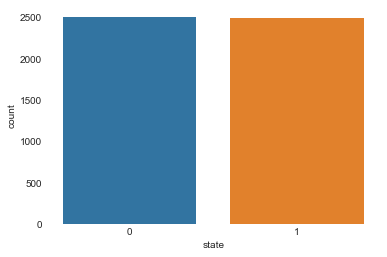

In [298]:
#Exploratory our target is not skewed so Random forest could be a good idea
sns.countplot(z)



                               sum_collect  sum_redeem  sum_collect_points  \
sum_collect                       1.000000    0.035956            0.135775   
sum_redeem                        0.035956    1.000000            0.276845   
sum_collect_points                0.135775    0.276845            1.000000   
sum_redeem_points                 0.024751    0.706044            0.305891   
years_in_the_program             -0.068855    0.157432            0.154688   
months_since_last_transaction    -0.276237    0.008265            0.082158   

                               sum_redeem_points  years_in_the_program  \
sum_collect                             0.024751             -0.068855   
sum_redeem                              0.706044              0.157432   
sum_collect_points                      0.305891              0.154688   
sum_redeem_points                       1.000000              0.124821   
years_in_the_program                    0.124821              1.000000   
months_si

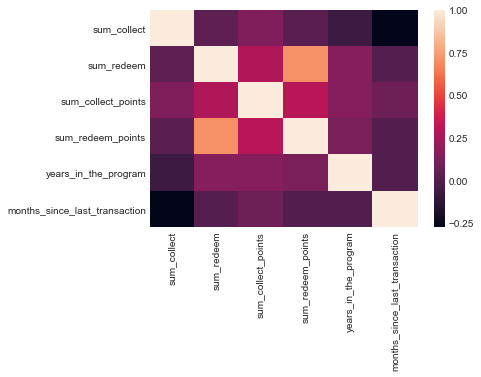

In [299]:
#correlations
df_num= df[['sum_collect','sum_redeem','sum_collect_points','sum_redeem_points','years_in_the_program','months_since_last_transaction']]
print(df_num.corr())
sns.heatmap(df_num.corr())

In [300]:
# --- Model Hyper Parameters Setting --- #
lr = LinearRegression(fit_intercept=True, normalize=False) # explain why this was bad (could have goine polynomial...)
rf = RandomForestClassifier()
    # parameters established after Grid Search Cross Validation - seen below

In [301]:
# --- Encode categorical variables - If selected model requires it --- #
#none one-hot encoding applied

In [302]:
# --- Model's k-fold cross validation evaluation procedure--- #

# param_grid = { 
#     'n_estimators': [200, 300, 400],
#     'min_samples_split': [5, 10],
#     'max_depth': [None, 5, 10]
# }

# clf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=9) # accuracy used as metric (9 chosen because of splits 500 each)
# print(clf.best_params_)

rf = RandomForestClassifier(
    n_estimators=200, criterion="gini", max_depth=None, max_features="sqrt", min_samples_split=10, random_state=70)
    # parameters established after Grid Search Cross Validation - seen above

In [303]:
# --- Split in training/validating and testing --- #
y = df["state"].values
del df["state"]
X = df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=70)

In [304]:
# --- Model building --- #
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=70, verbose=0, warm_start=False)

In [305]:
# --- Generate prediction --- #
y_pred = rf.predict(X_test)

Accuracy score is 86.4%.


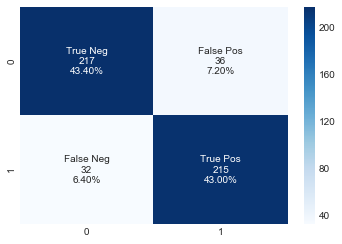

In [306]:
# --- Print metrics and confusion matrix --- #
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score is {}%.".format(100*accuracy))

cm = confusion_matrix(y_test, y_pred)
#plot confusion matrix

plt.figure(figsize=(6,4))
plt.xlabel("predicted")
plt.ylabel("Actual")
labels = ["True Neg’,’False Pos’,’False Neg’,’True Pos"]
categories = ["Zero", "One"]
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

Text(0.5,0,'False Positive Rate')

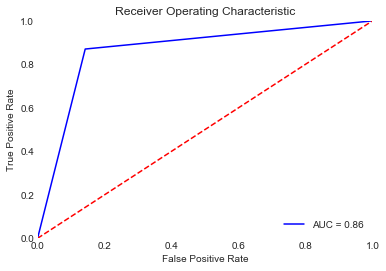

In [319]:
# --- Compute and plot Area Under Curve (AUC) --- #
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=None)
auc(fpr, tpr)
roc_auc = metrics.auc(fpr, tpr)

# plot AUC

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


[0.08650068 0.0023354  0.0737892  0.00398402 0.02610294 0.48227153
 0.06528522 0.08081451 0.06649115 0.02380293 0.06338339 0.02523904]
['sum_collect', 'sum_redeem', 'sum_collect_points', 'sum_redeem_points', 'years_in_the_program', 'months_since_last_transaction', 'point_usage', 'point_usage_frequency', 'average_collected_points_per_year', 'average_redeemed_points_per_year', 'average_collections_per_year', 'average_redemptions_per_year']


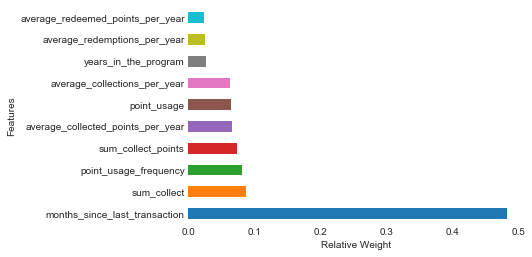

In [320]:
# --- Variable Importance Plot --- #
print(rf.feature_importances_)
print(features)

#Visualise
plt.xlabel('Relative Weight')
plt.ylabel('Features')
feat_importances = pd.Series(rf.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [321]:
# --- Save final Model to a file --- #
filename = 'propensity_model.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [ ]:
#the end